# Summarize CAV classifiers

In [53]:
import torch
import os
import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import motifs
from collections import defaultdict
from glob import glob
from matplotlib import gridspec
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support as score

In [30]:
# parameters
cav_root_dir = "output/512bp_regions_insert_3_motifs/cavs/"

motif_meme = "0_data/motif-clustering-v2.1beta_consensus_pwms.meme"

topN = 30 # how many motifs to plot, ranked by fscore

In [31]:
tcav_expts = []
for cav_dir in os.listdir(cav_root_dir):
    concept, control = cav_dir.split("_control_")
    tcav_expts.append((concept, control, os.path.join(cav_root_dir, cav_dir )))
tcav_expts = pd.DataFrame(tcav_expts, columns=['concept', 'control', 'cav_dir'])

In [32]:
tcav_expts

,concept,control,cav_dir
0,AC0001:GATA-PROP:GATA,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC00...
1,AC0002:PROP-ALX:Homeodomain,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC00...
2,AC0003:HNF1A-HNF1B:Homeodomain,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC00...
3,AC0004:ZSCAN:C2H2_ZF,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC00...
4,"AC0005:POU3F-POU1F:Homeodomain,POU",random_regions,output/512bp_regions_insert_3_motifs/cavs/AC00...
...,...,...,...
632,AC0633:TBX-MGA::EVX:T-box,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC06...
633,AC0634:ZNF:C2H2_ZF,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC06...
634,AC0635:TBX-EOMES:T-box,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC06...
635,AC0636:SREBF:bHLH,random_regions,output/512bp_regions_insert_3_motifs/cavs/AC06...


In [33]:
dfs = []
cavs = defaultdict(list)
tcavs = defaultdict(list)

fscores = []
for item in tqdm(tcav_expts.itertuples()):

    prefix_dir = item.cav_dir
    
    perform = pd.read_table(f"{prefix_dir}/classifier_perform_on_test.txt", 
                            comment="#")

    precision, recall, fscore, support = score(perform.Truth, perform.Pred)

    fscores.append(np.mean(fscore))

    # here predictions are model outputs, so it's usually expected that concepts 0 has a higher probability of being bound
    #model_predictions_0 = np.loadtxt(f"{prefix_dir}/predictions_concept_0.txt")
    #model_predictions_1 = np.loadtxt(f"{prefix_dir}/predictions_concept_1.txt")
    
    classifier_scores = pd.DataFrame({'precision': precision,
                  'recall': recall,
                  'fscore': fscore,
                  'support': support})

    dfs.append((np.mean(fscore), support, item.concept, item.control))

dfs_merge = pd.DataFrame(dfs, columns=['fscore', 'support', 'concept', 'rep'])

#dfs_merge['concept_name'] = dfs_merge.apply(lambda x: f'Random genome with\n{x["concept"]} inserted' if x['concept_id']==0 else 'Random genome', axis=1)

637it [00:11, 53.18it/s]


In [34]:
dfs_merge

,fscore,support,concept,rep
0,0.570113,"[469, 448]",AC0001:GATA-PROP:GATA,random_regions
1,0.627836,"[469, 456]",AC0002:PROP-ALX:Homeodomain,random_regions
2,0.624060,"[469, 462]",AC0003:HNF1A-HNF1B:Homeodomain,random_regions
3,0.882251,"[469, 483]",AC0004:ZSCAN:C2H2_ZF,random_regions
4,0.686810,"[469, 432]","AC0005:POU3F-POU1F:Homeodomain,POU",random_regions
...,...,...,...,...
632,0.683243,"[469, 415]",AC0633:TBX-MGA::EVX:T-box,random_regions
633,0.637607,"[469, 450]",AC0634:ZNF:C2H2_ZF,random_regions
634,0.502615,"[469, 440]",AC0635:TBX-EOMES:T-box,random_regions
635,0.645897,"[469, 463]",AC0636:SREBF:bHLH,random_regions


In [42]:
if topN is not None:
    df_plot = dfs_merge.sort_values('fscore', ascending=False).iloc[:topN]
else:
    df_plot = dfs_merge.sort_values('fscore', ascending=False)

In [73]:
motif_pwms = motifs.parse(open(motif_meme), fmt='MINIMAL')
motif_pwms = {m.name: m.pwm for m in motif_pwms} # index pwm by name
def seq_logo(concept, ax=None, max_len=20):
    pwm = motif_pwms.get(concept)

    if pwm is not None:    
        pwm_df = pd.DataFrame(pwm)
        motif_len = len(pwm_df)
        
        # Logomaker expects columns as A,C,G,T, so ensure correct order
        pwm_df = pwm_df[['A', 'C', 'G', 'T']]
    
        # Compute information content at each position (2 - entropy)
        def compute_ic(pwm_row):
            entropy = -sum([p * np.log2(p) if p > 0 else 0 for p in pwm_row])
            return 2 - entropy
        
        # Compute IC matrix: IC_letter = p * IC_total
        ic_df = pwm_df.copy()
        for i in range(len(pwm_df)):
            ic_total = compute_ic(pwm_df.iloc[i])
            ic_df.iloc[i] = pwm_df.iloc[i] * ic_total
    
        
        # Plot with logomaker
        x0, y0, width, height = ax.get_position().bounds
        ax.set_position([x0, y0, width * min(1., motif_len/max_len), height])
        logo = logomaker.Logo(ic_df, color_scheme={'A': 'red', 'C': 'blue',
                                                  'G': 'orange', 'T': 'green'},
                              ax=ax)
        logo.ax.axis('off')
    else:
        print(f"Can't find PWM for concept {concept}!")
        ax.axis('off')

Can't find PWM for concept AC0161:E2F-ZBTB:E2F!


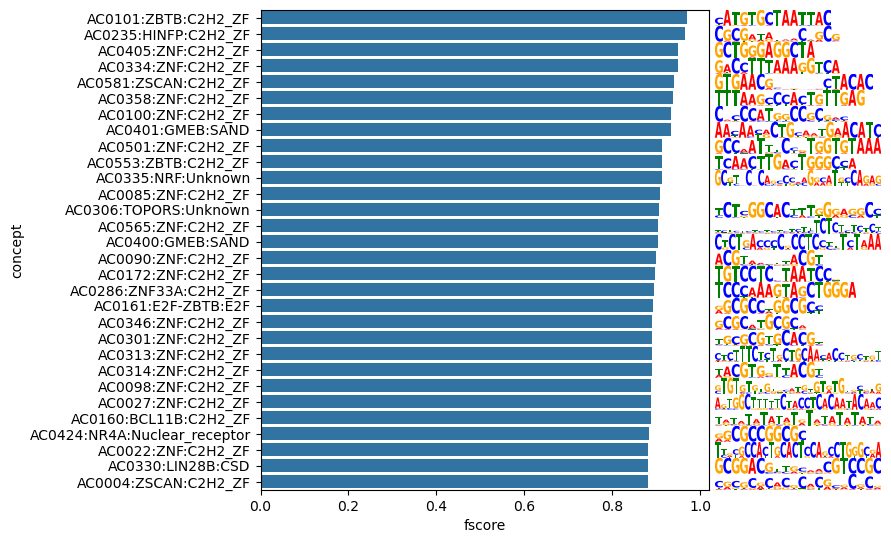

In [74]:
fig = plt.figure()

ax_bar = sns.barplot(data=df_plot, y='concept', x='fscore', orient="y")
ax_bar.set_position([0, 0, 0.7, 1])
ax_bar_bbox = ax_bar.get_position()

gs3 = gridspec.GridSpec(len(df_plot), 1)

logo_height = ax_bar_bbox.height/len(df_plot)
logo_width = 0.25
for i, (concept, g) in enumerate(zip(reversed(df_plot.concept.tolist()), gs3)):
    ax3 = plt.subplot(g)
    ax3.set_position([0.71, ax_bar_bbox.y0+i*logo_height, logo_width+0.01, logo_height])
    if concept is not None:
        seq_logo(concept, ax=ax3)
    else:
        ax3.axis('off')